# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-lc-kfold'
epochs = 10
batch_size = 32
sequence_length = 96
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [12]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [13]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'pornografi': [y_train_fold[i][0] for i in temp],
                'sara': [y_train_fold[i][1] for i in temp],
                'radikalisme': [y_train_fold[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [14]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[2:6]
X = data['processed_text'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Each element in these lists will be a list of metrics for one fold's learning curve
all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    # Set seed for reproducibility within the fold
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    # Adjust checkpoints based on the current fold's training size
    checkpoints = [
        # int(0.1 * total_train_fold_size)
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # 1. Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break

        model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
        
        # 3. Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        sampling_args = (model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        
        # 4. Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 388 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5963, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5233, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4851, Accuracy: 0.8166, F1 Micro: 0.2367, F1 Macro: 0.1613
Epoch 4/10, Train Loss: 0.4274, Accuracy: 0.8252, F1 Micro: 0.3327, F1 Macro: 0.227
Epoch 5/10, Train Loss: 0.3978, Accuracy: 0.8386, F1 Micro: 0.4661, F1 Macro: 0.3619
Epoch 6/10, Train Loss: 0.349, Accuracy: 0.8506, F1 Micro: 0.5631, F1 Macro: 0.5253
Epoch 7/10, Train Loss: 0.3106, Accuracy: 0.862, F1 Micro: 0.652, F1 Macro: 0.6434
Epoch 8/10, Train Loss: 0.2486, Accuracy: 0.8617, F1 Micro: 0.6641, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.2302, Accuracy: 0.8678, F1 Micro: 0.6874, F1 Macro: 0.684
Epoch 10/10, Train Loss: 0.1741, Accuracy: 0.8681, F1 Micro: 0.6544, F1 Macro: 0.6387
Best result for 388 samples: F1 Micro: 0.6874
                      precision    recall  f1-score   support

          pornografi       0.91      0.79      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4318, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.3333, Accuracy: 0.793, F1 Micro: 0.0265, F1 Macro: 0.0233
Epoch 3/10, Train Loss: 0.2506, Accuracy: 0.8275, F1 Micro: 0.3285, F1 Macro: 0.2426
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.8475, F1 Micro: 0.6484, F1 Macro: 0.6472
Epoch 5/10, Train Loss: 0.1758, Accuracy: 0.8608, F1 Micro: 0.6759, F1 Macro: 0.6649
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.8641, F1 Micro: 0.6559, F1 Macro: 0.6307
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.8656, F1 Micro: 0.6861, F1 Macro: 0.6778
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.8666, F1 Micro: 0.6952, F1 Macro: 0.6909
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.8698, F1 Micro: 0.6737, F1 Macro: 0.6641
Epoch 10/10, Train Loss: 0.062, Accuracy: 0.8691, F1 Micro: 0.6816, F1 Macro: 0.6753
Best result for 971 samples: F1 Micro: 0.6952
                      precision    recall  f1-score   support

          pornografi       0.87      0.83      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.7941, F1 Micro: 0.0365, F1 Macro: 0.0317
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.8459, F1 Micro: 0.5754, F1 Macro: 0.5479
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.8572, F1 Micro: 0.6786, F1 Macro: 0.676
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.8658, F1 Micro: 0.6935, F1 Macro: 0.6838
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.865, F1 Micro: 0.6851, F1 Macro: 0.6833
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.8681, F1 Micro: 0.6731, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.8705, F1 Micro: 0.6244, F1 Macro: 0.5988
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.8692, F1 Micro: 0.6922, F1 Macro: 0.6872
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.8758, F1 Micro: 0.6821, F1 Macro: 0.6689
Best result for 1496 samples: F1 Micro: 0.6935
                      precision    recall  f1-score   support

          pornografi       0.91      0.82      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3145, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.8184, F1 Micro: 0.3165, F1 Macro: 0.2231
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.86, F1 Micro: 0.6334, F1 Macro: 0.6148
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.8653, F1 Micro: 0.6085, F1 Macro: 0.5623
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.8666, F1 Micro: 0.6895, F1 Macro: 0.6852
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.857, F1 Micro: 0.6977, F1 Macro: 0.6978
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.8702, F1 Micro: 0.7023, F1 Macro: 0.6936
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.8694, F1 Micro: 0.6986, F1 Macro: 0.6965
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8722, F1 Micro: 0.7072, F1 Macro: 0.7009
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.8814, F1 Micro: 0.7075, F1 Macro: 0.7018
Best result for 1969 samples: F1 Micro: 0.7075
                      precision    recall  f1-score   support

          pornografi       0.93      0.84      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.8159, F1 Micro: 0.2199, F1 Macro: 0.1662
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.8617, F1 Micro: 0.5953, F1 Macro: 0.5753
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.875, F1 Micro: 0.694, F1 Macro: 0.6697
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.8702, F1 Micro: 0.704, F1 Macro: 0.6987
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.8698, F1 Micro: 0.7162, F1 Macro: 0.7144
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.8836, F1 Micro: 0.7288, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.8769, F1 Micro: 0.7301, F1 Macro: 0.7296
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.878, F1 Micro: 0.7274, F1 Macro: 0.7239
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.8819, F1 Micro: 0.7306, F1 Macro: 0.7294
Best result for 2394 samples: F1 Micro: 0.7306
                      precision    recall  f1-score   support

          pornografi       0.92      0.86      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3392, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.8297, F1 Micro: 0.3677, F1 Macro: 0.2786
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.8773, F1 Micro: 0.694, F1 Macro: 0.6904
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.8805, F1 Micro: 0.7106, F1 Macro: 0.7014
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.8759, F1 Micro: 0.7243, F1 Macro: 0.7227
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.8845, F1 Micro: 0.7288, F1 Macro: 0.7251
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.8773, F1 Micro: 0.7329, F1 Macro: 0.7332
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.89, F1 Micro: 0.7373, F1 Macro: 0.7349
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.8878, F1 Micro: 0.7421, F1 Macro: 0.7392
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.8889, F1 Micro: 0.7456, F1 Macro: 0.7427
Best result for 2777 samples: F1 Micro: 0.7456
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.8567, F1 Micro: 0.6234, F1 Macro: 0.628
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.8781, F1 Micro: 0.7048, F1 Macro: 0.7032
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.8842, F1 Micro: 0.7184, F1 Macro: 0.7099
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.8853, F1 Micro: 0.7455, F1 Macro: 0.7431
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.888, F1 Micro: 0.7449, F1 Macro: 0.7433
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.8859, F1 Micro: 0.7448, F1 Macro: 0.7436
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.8931, F1 Micro: 0.744, F1 Macro: 0.738
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.8919, F1 Micro: 0.7496, F1 Macro: 0.7483
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.8922, F1 Micro: 0.7509, F1 Macro: 0.7494
Best result for 3122 samples: F1 Micro: 0.7509
                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.358, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.8581, F1 Micro: 0.5899, F1 Macro: 0.5457
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.8822, F1 Micro: 0.7075, F1 Macro: 0.7075
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.8881, F1 Micro: 0.7334, F1 Macro: 0.7271
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.8891, F1 Micro: 0.7459, F1 Macro: 0.7444
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.8755, F1 Micro: 0.7364, F1 Macro: 0.7414
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.8944, F1 Micro: 0.7462, F1 Macro: 0.7446
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.8955, F1 Micro: 0.7523, F1 Macro: 0.7485
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.8897, F1 Micro: 0.7502, F1 Macro: 0.7488
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.8916, F1 Micro: 0.7445, F1 Macro: 0.7374
Best result for 3432 samples: F1 Micro: 0.7523
                      precision    recall  f1-score   support

          pornografi       0.95      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8002, F1 Micro: 0.0974, F1 Macro: 0.0895
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.8714, F1 Micro: 0.6227, F1 Macro: 0.6091
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.8797, F1 Micro: 0.7399, F1 Macro: 0.7417
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.8927, F1 Micro: 0.7506, F1 Macro: 0.748
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.8956, F1 Micro: 0.747, F1 Macro: 0.7373
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9003, F1 Micro: 0.7529, F1 Macro: 0.7459
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.8947, F1 Micro: 0.7577, F1 Macro: 0.754
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.8967, F1 Micro: 0.756, F1 Macro: 0.7562
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.8959, F1 Micro: 0.7611, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0269, Accuracy: 0.8964, F1 Micro: 0.759, F1 Macro: 0.7551
Best result for 3711 samples: F1 Micro: 0.7611
                      precision    recall  f1-score   support

          pornografi       0.96      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8255, F1 Micro: 0.2988, F1 Macro: 0.245
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.8719, F1 Micro: 0.6717, F1 Macro: 0.6486
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.8878, F1 Micro: 0.7438, F1 Macro: 0.7401
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.892, F1 Micro: 0.7542, F1 Macro: 0.754
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.8944, F1 Micro: 0.7432, F1 Macro: 0.7398
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.8898, F1 Micro: 0.7566, F1 Macro: 0.7589
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.8969, F1 Micro: 0.7584, F1 Macro: 0.7563
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8966, F1 Micro: 0.7502, F1 Macro: 0.7472
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.8939, F1 Micro: 0.7584, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.8948, F1 Micro: 0.7568, F1 Macro: 0.7549
Best result for 3886 samples: F1 Micro: 0.7584
                      precision    recall  f1-score   support

          pornografi       0.94      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8258, F1 Micro: 0.3027, F1 Macro: 0.2327
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.8809, F1 Micro: 0.6707, F1 Macro: 0.6463
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.8938, F1 Micro: 0.7428, F1 Macro: 0.737
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.8955, F1 Micro: 0.7655, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.897, F1 Micro: 0.7603, F1 Macro: 0.7612
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.8936, F1 Micro: 0.7555, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8986, F1 Micro: 0.7572, F1 Macro: 0.7553
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.8956, F1 Micro: 0.7623, F1 Macro: 0.7628
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.898, F1 Micro: 0.7595, F1 Macro: 0.7592
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9003, F1 Micro: 0.766, F1 Macro: 0.7634
Best result for 4120 samples: F1 Micro: 0.766
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8575, F1 Micro: 0.5774, F1 Macro: 0.5261
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.8928, F1 Micro: 0.7249, F1 Macro: 0.7146
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.8947, F1 Micro: 0.7342, F1 Macro: 0.7182
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.8991, F1 Micro: 0.7549, F1 Macro: 0.753
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.8963, F1 Micro: 0.7629, F1 Macro: 0.7623
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9041, F1 Micro: 0.7697, F1 Macro: 0.7667
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.8997, F1 Micro: 0.7672, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9006, F1 Micro: 0.7571, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.8969, F1 Micro: 0.7616, F1 Macro: 0.762
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9008, F1 Micro: 0.7692, F1 Macro: 0.7694
Best result for 4330 samples: F1 Micro: 0.7697
                      precision    recall  f1-score   support

          pornografi       0.92      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8698, F1 Micro: 0.6765, F1 Macro: 0.6694
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.8903, F1 Micro: 0.7386, F1 Macro: 0.7258
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.8969, F1 Micro: 0.7498, F1 Macro: 0.7363
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9042, F1 Micro: 0.7693, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9009, F1 Micro: 0.765, F1 Macro: 0.7619
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9041, F1 Micro: 0.7656, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9025, F1 Micro: 0.7652, F1 Macro: 0.7636
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.8973, F1 Micro: 0.7691, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9011, F1 Micro: 0.7625, F1 Macro: 0.7537
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9002, F1 Micro: 0.7634, F1 Macro: 0.7612
Best result for 4530 samples: F1 Micro: 0.7693
                      precision    recall  f1-score   support

          pornografi       0.94      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8614, F1 Micro: 0.6453, F1 Macro: 0.6469
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.8923, F1 Micro: 0.7209, F1 Macro: 0.6936
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.8975, F1 Micro: 0.7659, F1 Macro: 0.7647
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9066, F1 Micro: 0.7684, F1 Macro: 0.7642
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9027, F1 Micro: 0.7705, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9023, F1 Micro: 0.7735, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.8967, F1 Micro: 0.7706, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9038, F1 Micro: 0.7691, F1 Macro: 0.7692
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9047, F1 Micro: 0.7757, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.8989, F1 Micro: 0.7708, F1 Macro: 0.7726
Best result for 4663 samples: F1 Micro: 0.7757
                      precision    recall  f1-score   support

          pornografi       0.94      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4037, Accuracy: 0.8653, F1 Micro: 0.6692, F1 Macro: 0.6672
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.8928, F1 Micro: 0.7236, F1 Macro: 0.7125
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.8988, F1 Micro: 0.7538, F1 Macro: 0.74
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9013, F1 Micro: 0.7626, F1 Macro: 0.7584
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9061, F1 Micro: 0.7661, F1 Macro: 0.7564
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.908, F1 Micro: 0.7721, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9058, F1 Micro: 0.7687, F1 Macro: 0.7615
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9038, F1 Micro: 0.7708, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9069, F1 Micro: 0.773, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.8963, F1 Micro: 0.7682, F1 Macro: 0.7712
Best result for 4863 samples: F1 Micro: 0.773
                      precision    recall  f1-score   support

          pornografi       0.96      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8739, F1 Micro: 0.6664, F1 Macro: 0.66
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.8972, F1 Micro: 0.7418, F1 Macro: 0.7301
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9008, F1 Micro: 0.7666, F1 Macro: 0.764
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9008, F1 Micro: 0.7665, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9022, F1 Micro: 0.7774, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.8963, F1 Micro: 0.7665, F1 Macro: 0.7667
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.902, F1 Micro: 0.7736, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9028, F1 Micro: 0.7763, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9013, F1 Micro: 0.7772, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.8984, F1 Micro: 0.7697, F1 Macro: 0.7671
Best result for 5063 samples: F1 Micro: 0.7774
                      precision    recall  f1-score   support

          pornografi       0.92      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8753, F1 Micro: 0.6885, F1 Macro: 0.6847
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.8967, F1 Micro: 0.7445, F1 Macro: 0.7339
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9033, F1 Micro: 0.7545, F1 Macro: 0.7451
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9038, F1 Micro: 0.7695, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.8997, F1 Micro: 0.7648, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.903, F1 Micro: 0.7714, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9047, F1 Micro: 0.7677, F1 Macro: 0.7648
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9047, F1 Micro: 0.7643, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9025, F1 Micro: 0.7679, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9023, F1 Micro: 0.7575, F1 Macro: 0.7481
Best result for 5263 samples: F1 Micro: 0.7714
                      precision    recall  f1-score   support

          pornografi       0.94      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8786, F1 Micro: 0.6845, F1 Macro: 0.6733
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.8963, F1 Micro: 0.7444, F1 Macro: 0.7403
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9005, F1 Micro: 0.7631, F1 Macro: 0.7616
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9009, F1 Micro: 0.7631, F1 Macro: 0.7615
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.8995, F1 Micro: 0.7698, F1 Macro: 0.7683
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.903, F1 Micro: 0.7762, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9044, F1 Micro: 0.7752, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9045, F1 Micro: 0.7638, F1 Macro: 0.758
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9062, F1 Micro: 0.7678, F1 Macro: 0.7588
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9061, F1 Micro: 0.7707, F1 Macro: 0.7676
Best result for 5441 samples: F1 Micro: 0.7762
                      precision    recall  f1-score   support

          pornografi       0.93      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8808, F1 Micro: 0.7082, F1 Macro: 0.6998
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.8988, F1 Micro: 0.751, F1 Macro: 0.7462
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9022, F1 Micro: 0.7549, F1 Macro: 0.7506
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9066, F1 Micro: 0.7638, F1 Macro: 0.7601
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9016, F1 Micro: 0.7702, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.8984, F1 Micro: 0.769, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9025, F1 Micro: 0.7684, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9055, F1 Micro: 0.7699, F1 Macro: 0.7666
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9044, F1 Micro: 0.7664, F1 Macro: 0.7607
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macro: 0.7642
Best result for 5641 samples: F1 Micro: 0.7702
                      precision    recall  f1-score   support

          pornografi       0.93      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8872, F1 Micro: 0.7197, F1 Macro: 0.7087
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9011, F1 Micro: 0.7572, F1 Macro: 0.7472
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.907, F1 Micro: 0.7662, F1 Macro: 0.7636
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9064, F1 Micro: 0.7808, F1 Macro: 0.7806
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9062, F1 Micro: 0.7799, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9048, F1 Micro: 0.766, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9067, F1 Micro: 0.7777, F1 Macro: 0.7729
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.903, F1 Micro: 0.7726, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9005, F1 Micro: 0.7755, F1 Macro: 0.7786
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9036, F1 Micro: 0.7673, F1 Macro: 0.7642
Best result for 5841 samples: F1 Micro: 0.7808
                      precision    recall  f1-score   support

          pornografi       0.94      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8845, F1 Micro: 0.7135, F1 Macro: 0.709
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.8997, F1 Micro: 0.7527, F1 Macro: 0.7379
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9056, F1 Micro: 0.767, F1 Macro: 0.7571
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9039, F1 Micro: 0.7671, F1 Macro: 0.76
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9022, F1 Micro: 0.7681, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9055, F1 Micro: 0.7775, F1 Macro: 0.7747
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.8992, F1 Micro: 0.7757, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9058, F1 Micro: 0.7761, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9036, F1 Micro: 0.7667, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9047, F1 Micro: 0.7757, F1 Macro: 0.7728
Best result for 6041 samples: F1 Micro: 0.7775
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3675, Accuracy: 0.89, F1 Micro: 0.7186, F1 Macro: 0.7041
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9005, F1 Micro: 0.7592, F1 Macro: 0.7548
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9045, F1 Micro: 0.7631, F1 Macro: 0.7534
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9069, F1 Micro: 0.7603, F1 Macro: 0.7471
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9087, F1 Micro: 0.7801, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9066, F1 Micro: 0.7782, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9028, F1 Micro: 0.7656, F1 Macro: 0.7579
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9028, F1 Micro: 0.7732, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.905, F1 Micro: 0.7738, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9047, F1 Micro: 0.7666, F1 Macro: 0.7623
Best result for 6218 samples: F1 Micro: 0.7801
                      precision    recall  f1-score   support

          pornografi       0.91      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4954, Accuracy: 0.7953, F1 Micro: 0.099, F1 Macro: 0.08
Epoch 3/10, Train Loss: 0.448, Accuracy: 0.8238, F1 Micro: 0.3229, F1 Macro: 0.2108
Epoch 4/10, Train Loss: 0.3886, Accuracy: 0.8323, F1 Micro: 0.3975, F1 Macro: 0.3047
Epoch 5/10, Train Loss: 0.3358, Accuracy: 0.8384, F1 Micro: 0.4615, F1 Macro: 0.3692
Epoch 6/10, Train Loss: 0.2851, Accuracy: 0.8464, F1 Micro: 0.5131, F1 Macro: 0.4513
Epoch 7/10, Train Loss: 0.2509, Accuracy: 0.8661, F1 Micro: 0.6355, F1 Macro: 0.5946
Epoch 8/10, Train Loss: 0.2376, Accuracy: 0.872, F1 Micro: 0.6667, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.188, Accuracy: 0.8628, F1 Micro: 0.6132, F1 Macro: 0.5838
Epoch 10/10, Train Loss: 0.1613, Accuracy: 0.8709, F1 Micro: 0.6541, F1 Macro: 0.628
Best result for 388 samples: F1 Micro: 0.6667
                      precision    recall  f1-score   support

          pornografi       0.94      0.80      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.402, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2967, Accuracy: 0.8153, F1 Micro: 0.2538, F1 Macro: 0.1736
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.8333, F1 Micro: 0.4352, F1 Macro: 0.2894
Epoch 4/10, Train Loss: 0.2002, Accuracy: 0.8512, F1 Micro: 0.5673, F1 Macro: 0.5179
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.8705, F1 Micro: 0.6685, F1 Macro: 0.6323
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.8744, F1 Micro: 0.6768, F1 Macro: 0.6487
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.8723, F1 Micro: 0.6939, F1 Macro: 0.6839
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.8714, F1 Micro: 0.7049, F1 Macro: 0.6857
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.8752, F1 Micro: 0.7006, F1 Macro: 0.6828
Epoch 10/10, Train Loss: 0.0521, Accuracy: 0.873, F1 Micro: 0.6741, F1 Macro: 0.6491
Best result for 971 samples: F1 Micro: 0.7049
                      precision    recall  f1-score   support

          pornografi       0.84      0.89      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3173, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2208, Accuracy: 0.8123, F1 Micro: 0.2326, F1 Macro: 0.1629
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.8336, F1 Micro: 0.4221, F1 Macro: 0.2893
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.8627, F1 Micro: 0.6457, F1 Macro: 0.5992
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.8609, F1 Micro: 0.6096, F1 Macro: 0.5966
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.873, F1 Micro: 0.7128, F1 Macro: 0.7103
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.8723, F1 Micro: 0.7191, F1 Macro: 0.7074
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.877, F1 Micro: 0.7186, F1 Macro: 0.7113
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.873, F1 Micro: 0.7124, F1 Macro: 0.6991
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.8753, F1 Micro: 0.7206, F1 Macro: 0.7095
Best result for 1496 samples: F1 Micro: 0.7206
                      precision    recall  f1-score   support

          pornografi       0.88      0.88      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.2976, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.8186, F1 Micro: 0.2838, F1 Macro: 0.1888
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.8634, F1 Micro: 0.6736, F1 Macro: 0.635
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.867, F1 Micro: 0.6761, F1 Macro: 0.6684
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.8748, F1 Micro: 0.7101, F1 Macro: 0.7063
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.8781, F1 Micro: 0.725, F1 Macro: 0.7077
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.8814, F1 Micro: 0.7338, F1 Macro: 0.7241
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.8789, F1 Micro: 0.7299, F1 Macro: 0.724
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.8798, F1 Micro: 0.7398, F1 Macro: 0.7325
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.8778, F1 Micro: 0.7142, F1 Macro: 0.7104
Best result for 1969 samples: F1 Micro: 0.7398
                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.2977, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.8283, F1 Micro: 0.3584, F1 Macro: 0.2542
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.8716, F1 Micro: 0.7081, F1 Macro: 0.6996
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.8727, F1 Micro: 0.7367, F1 Macro: 0.7299
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.8823, F1 Micro: 0.7401, F1 Macro: 0.7327
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.8808, F1 Micro: 0.7474, F1 Macro: 0.7402
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.8841, F1 Micro: 0.7352, F1 Macro: 0.7291
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.8867, F1 Micro: 0.7533, F1 Macro: 0.7421
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.8898, F1 Micro: 0.7463, F1 Macro: 0.7345
Epoch 10/10, Train Loss: 0.0231, Accuracy: 0.8878, F1 Micro: 0.7526, F1 Macro: 0.7502
Best result for 2394 samples: F1 Micro: 0.7533
                      precision    recall  f1-score   support

          pornografi       0.91      0.90     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3298, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.8564, F1 Micro: 0.5659, F1 Macro: 0.5023
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.8816, F1 Micro: 0.6948, F1 Macro: 0.6834
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.8758, F1 Micro: 0.6481, F1 Macro: 0.6039
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.8936, F1 Micro: 0.7613, F1 Macro: 0.7607
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.8928, F1 Micro: 0.7312, F1 Macro: 0.7088
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.8978, F1 Micro: 0.7599, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.8963, F1 Micro: 0.7494, F1 Macro: 0.743
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.8955, F1 Micro: 0.7605, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.8908, F1 Micro: 0.7607, F1 Macro: 0.7553
Best result for 2777 samples: F1 Micro: 0.7613
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3396, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.8436, F1 Micro: 0.4575, F1 Macro: 0.393
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.8792, F1 Micro: 0.6748, F1 Macro: 0.6266
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.8953, F1 Micro: 0.7688, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.8875, F1 Micro: 0.7659, F1 Macro: 0.7631
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9, F1 Micro: 0.7678, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9022, F1 Micro: 0.7814, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.8966, F1 Micro: 0.7667, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.8978, F1 Micro: 0.7708, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.8998, F1 Micro: 0.7656, F1 Macro: 0.7607
Best result for 3122 samples: F1 Micro: 0.7814
                      precision    recall  f1-score   support

          pornografi       0.93      0.93      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.8678, F1 Micro: 0.624, F1 Macro: 0.6074
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.8906, F1 Micro: 0.718, F1 Macro: 0.7176
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9011, F1 Micro: 0.7737, F1 Macro: 0.7678
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9013, F1 Micro: 0.784, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.8995, F1 Micro: 0.7688, F1 Macro: 0.7488
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9003, F1 Micro: 0.7789, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9052, F1 Micro: 0.7912, F1 Macro: 0.7863
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9038, F1 Micro: 0.7776, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.9006, F1 Micro: 0.7838, F1 Macro: 0.7788
Best result for 3432 samples: F1 Micro: 0.7912
                      precision    recall  f1-score   support

          pornografi       0.92      0.93      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8339, F1 Micro: 0.4058, F1 Macro: 0.3233
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.8875, F1 Micro: 0.7176, F1 Macro: 0.7171
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.903, F1 Micro: 0.7708, F1 Macro: 0.76
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9062, F1 Micro: 0.7828, F1 Macro: 0.7784
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9039, F1 Micro: 0.7716, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.905, F1 Micro: 0.7779, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9033, F1 Micro: 0.7827, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9069, F1 Micro: 0.7881, F1 Macro: 0.7817
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9086, F1 Micro: 0.7941, F1 Macro: 0.7866
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9052, F1 Micro: 0.7766, F1 Macro: 0.7697
Best result for 3711 samples: F1 Micro: 0.7941
                      precision    recall  f1-score   support

          pornografi       0.93      0.92    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8438, F1 Micro: 0.4759, F1 Macro: 0.411
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.8934, F1 Micro: 0.7468, F1 Macro: 0.7461
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9, F1 Micro: 0.7858, F1 Macro: 0.7842
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9041, F1 Micro: 0.7906, F1 Macro: 0.7888
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9086, F1 Micro: 0.7901, F1 Macro: 0.7817
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9053, F1 Micro: 0.7942, F1 Macro: 0.7925
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9081, F1 Micro: 0.794, F1 Macro: 0.7865
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9077, F1 Micro: 0.7939, F1 Macro: 0.7888
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9052, F1 Micro: 0.7883, F1 Macro: 0.7855
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9077, F1 Micro: 0.7966, F1 Macro: 0.789
Best result for 3886 samples: F1 Micro: 0.7966
                      precision    recall  f1-score   support

          pornografi       0.95      0.92    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8569, F1 Micro: 0.5562, F1 Macro: 0.477
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.8983, F1 Micro: 0.7628, F1 Macro: 0.7475
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.8991, F1 Micro: 0.7653, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9105, F1 Micro: 0.7929, F1 Macro: 0.7814
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9116, F1 Micro: 0.801, F1 Macro: 0.7971
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9055, F1 Micro: 0.793, F1 Macro: 0.7859
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9066, F1 Micro: 0.7951, F1 Macro: 0.7907
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9087, F1 Micro: 0.7938, F1 Macro: 0.7878
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9061, F1 Micro: 0.7908, F1 Macro: 0.7848
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9073, F1 Micro: 0.7945, F1 Macro: 0.7898
Best result for 4120 samples: F1 Micro: 0.801
                      precision    recall  f1-score   support

          pornografi       0.94      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8686, F1 Micro: 0.6364, F1 Macro: 0.6202
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.897, F1 Micro: 0.7464, F1 Macro: 0.739
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9028, F1 Micro: 0.7576, F1 Macro: 0.7375
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9098, F1 Micro: 0.7898, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9061, F1 Micro: 0.7703, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9086, F1 Micro: 0.7995, F1 Macro: 0.7973
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9045, F1 Micro: 0.7869, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9056, F1 Micro: 0.7907, F1 Macro: 0.7875
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.908, F1 Micro: 0.7778, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9056, F1 Micro: 0.7834, F1 Macro: 0.7807
Best result for 4330 samples: F1 Micro: 0.7995
                      precision    recall  f1-score   support

          pornografi       0.95      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8481, F1 Micro: 0.5193, F1 Macro: 0.4601
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.9017, F1 Micro: 0.7707, F1 Macro: 0.7677
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9008, F1 Micro: 0.7799, F1 Macro: 0.7791
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9087, F1 Micro: 0.7958, F1 Macro: 0.7931
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9084, F1 Micro: 0.7846, F1 Macro: 0.7765
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9095, F1 Micro: 0.7966, F1 Macro: 0.7955
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9084, F1 Micro: 0.795, F1 Macro: 0.7925
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9073, F1 Micro: 0.788, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9061, F1 Micro: 0.7867, F1 Macro: 0.7835
Best result for 4530 samples: F1 Micro: 0.7966
                      precision    recall  f1-score   support

          pornografi       0.95      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.8828, F1 Micro: 0.714, F1 Macro: 0.6884
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.9013, F1 Micro: 0.774, F1 Macro: 0.774
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9047, F1 Micro: 0.7845, F1 Macro: 0.7843
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9047, F1 Micro: 0.7828, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9066, F1 Micro: 0.7873, F1 Macro: 0.7744
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.905, F1 Micro: 0.7954, F1 Macro: 0.7927
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9067, F1 Micro: 0.785, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9091, F1 Micro: 0.7908, F1 Macro: 0.7892
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9056, F1 Micro: 0.7838, F1 Macro: 0.7785
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9056, F1 Micro: 0.7901, F1 Macro: 0.7844
Best result for 4663 samples: F1 Micro: 0.7954
                      precision    recall  f1-score   support

          pornografi       0.94      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8766, F1 Micro: 0.7023, F1 Macro: 0.7015
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.9047, F1 Micro: 0.7815, F1 Macro: 0.7766
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9053, F1 Micro: 0.768, F1 Macro: 0.754
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9083, F1 Micro: 0.7825, F1 Macro: 0.7809
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9078, F1 Micro: 0.7873, F1 Macro: 0.7837
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9081, F1 Micro: 0.7894, F1 Macro: 0.7895
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9077, F1 Micro: 0.7892, F1 Macro: 0.7832
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9119, F1 Micro: 0.7958, F1 Macro: 0.7853
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9089, F1 Micro: 0.7902, F1 Macro: 0.7909
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.9072, F1 Micro: 0.7816, F1 Macro: 0.7773
Best result for 4863 samples: F1 Micro: 0.7958
                      precision    recall  f1-score   support

          pornografi       0.94      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8819, F1 Micro: 0.7271, F1 Macro: 0.7246
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9016, F1 Micro: 0.7716, F1 Macro: 0.7722
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.8984, F1 Micro: 0.7343, F1 Macro: 0.7044
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9095, F1 Micro: 0.7867, F1 Macro: 0.7781
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9072, F1 Micro: 0.7888, F1 Macro: 0.7803
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.91, F1 Micro: 0.7944, F1 Macro: 0.7906
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9111, F1 Micro: 0.7957, F1 Macro: 0.7935
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.907, F1 Micro: 0.781, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9112, F1 Micro: 0.7964, F1 Macro: 0.7913
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.905, F1 Micro: 0.7921, F1 Macro: 0.7917
Best result for 5063 samples: F1 Micro: 0.7964
                      precision    recall  f1-score   support

          pornografi       0.95      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8848, F1 Micro: 0.702, F1 Macro: 0.6912
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9027, F1 Micro: 0.7612, F1 Macro: 0.7328
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9089, F1 Micro: 0.7959, F1 Macro: 0.7925
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9109, F1 Micro: 0.7901, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.908, F1 Micro: 0.7933, F1 Macro: 0.7908
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9052, F1 Micro: 0.7691, F1 Macro: 0.7545
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9098, F1 Micro: 0.7996, F1 Macro: 0.7958
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.91, F1 Micro: 0.7931, F1 Macro: 0.7879
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9098, F1 Micro: 0.7851, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9053, F1 Micro: 0.7699, F1 Macro: 0.7596
Best result for 5263 samples: F1 Micro: 0.7996
                      precision    recall  f1-score   support

          pornografi       0.93      0.93    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3746, Accuracy: 0.8936, F1 Micro: 0.7548, F1 Macro: 0.7493
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9055, F1 Micro: 0.7799, F1 Macro: 0.7789
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9078, F1 Micro: 0.7794, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.912, F1 Micro: 0.7886, F1 Macro: 0.7764
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9097, F1 Micro: 0.7782, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9106, F1 Micro: 0.7885, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9041, F1 Micro: 0.7975, F1 Macro: 0.7956
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.907, F1 Micro: 0.7885, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.91, F1 Micro: 0.8, F1 Macro: 0.7965
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9084, F1 Micro: 0.795, F1 Macro: 0.7926
Best result for 5441 samples: F1 Micro: 0.8
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3653, Accuracy: 0.8947, F1 Micro: 0.7576, F1 Macro: 0.7454
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9052, F1 Micro: 0.7795, F1 Macro: 0.7754
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.912, F1 Micro: 0.8001, F1 Macro: 0.7914
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9098, F1 Micro: 0.7939, F1 Macro: 0.7908
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9062, F1 Micro: 0.7887, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9077, F1 Micro: 0.7954, F1 Macro: 0.7936
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.905, F1 Micro: 0.8, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9087, F1 Micro: 0.7842, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9075, F1 Micro: 0.7901, F1 Macro: 0.7848
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9111, F1 Micro: 0.7913, F1 Macro: 0.7837
Best result for 5641 samples: F1 Micro: 0.8001
                      precision    recall  f1-score   support

          pornografi       0.93      0.91    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8925, F1 Micro: 0.765, F1 Macro: 0.7634
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9073, F1 Micro: 0.7921, F1 Macro: 0.7879
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9052, F1 Micro: 0.7928, F1 Macro: 0.7894
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.912, F1 Micro: 0.8069, F1 Macro: 0.8029
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9105, F1 Micro: 0.7899, F1 Macro: 0.7803
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9122, F1 Micro: 0.8039, F1 Macro: 0.8005
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9125, F1 Micro: 0.7949, F1 Macro: 0.7856
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9091, F1 Micro: 0.8014, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9102, F1 Micro: 0.7914, F1 Macro: 0.7842
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9078, F1 Micro: 0.7785, F1 Macro: 0.7674
Best result for 5841 samples: F1 Micro: 0.8069
                      precision    recall  f1-score   support

          pornografi       0.94      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.8967, F1 Micro: 0.7654, F1 Macro: 0.7608
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9067, F1 Micro: 0.7786, F1 Macro: 0.7705
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9084, F1 Micro: 0.7842, F1 Macro: 0.7733
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9092, F1 Micro: 0.7954, F1 Macro: 0.7918
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9077, F1 Micro: 0.7961, F1 Macro: 0.7942
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9045, F1 Micro: 0.7649, F1 Macro: 0.7482
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9095, F1 Micro: 0.7901, F1 Macro: 0.7824
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9106, F1 Micro: 0.7953, F1 Macro: 0.793
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9116, F1 Micro: 0.7945, F1 Macro: 0.7887
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9086, F1 Micro: 0.7937, F1 Macro: 0.7839
Best result for 6041 samples: F1 Micro: 0.7961
                      precision    recall  f1-score   support

          pornografi       0.93      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8948, F1 Micro: 0.7575, F1 Macro: 0.7564
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9048, F1 Micro: 0.7727, F1 Macro: 0.762
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9077, F1 Micro: 0.7936, F1 Macro: 0.7875
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9119, F1 Micro: 0.8011, F1 Macro: 0.7969
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9019, F1 Micro: 0.7556, F1 Macro: 0.7386
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9078, F1 Micro: 0.8016, F1 Macro: 0.7972
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9087, F1 Micro: 0.7892, F1 Macro: 0.7832
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9075, F1 Micro: 0.7759, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9062, F1 Micro: 0.7887, F1 Macro: 0.7833
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9083, F1 Micro: 0.7945, F1 Macro: 0.788
Best result for 6218 samples: F1 Micro: 0.8016
                      precision    recall  f1-score   support

          pornografi       0.94      0.92 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6513, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4812, Accuracy: 0.7903, F1 Micro: 0.1183, F1 Macro: 0.098
Epoch 4/10, Train Loss: 0.4323, Accuracy: 0.8141, F1 Micro: 0.2942, F1 Macro: 0.2249
Epoch 5/10, Train Loss: 0.3936, Accuracy: 0.8339, F1 Micro: 0.4907, F1 Macro: 0.409
Epoch 6/10, Train Loss: 0.3469, Accuracy: 0.8489, F1 Micro: 0.565, F1 Macro: 0.4941
Epoch 7/10, Train Loss: 0.2903, Accuracy: 0.8502, F1 Micro: 0.5889, F1 Macro: 0.5297
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.8589, F1 Micro: 0.6596, F1 Macro: 0.6437
Epoch 9/10, Train Loss: 0.1973, Accuracy: 0.8583, F1 Micro: 0.6931, F1 Macro: 0.6907
Epoch 10/10, Train Loss: 0.1624, Accuracy: 0.8569, F1 Micro: 0.6041, F1 Macro: 0.5588
Best result for 388 samples: F1 Micro: 0.6931
                      precision    recall  f1-score   support

          pornografi       0.86      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4669, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.295, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.8109, F1 Micro: 0.3481, F1 Macro: 0.2645
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.8448, F1 Micro: 0.5537, F1 Macro: 0.491
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.8578, F1 Micro: 0.6676, F1 Macro: 0.6507
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.8603, F1 Micro: 0.6173, F1 Macro: 0.6054
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.8681, F1 Micro: 0.681, F1 Macro: 0.664
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.8692, F1 Micro: 0.7083, F1 Macro: 0.7022
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.8616, F1 Micro: 0.6439, F1 Macro: 0.6264
Epoch 10/10, Train Loss: 0.0479, Accuracy: 0.8644, F1 Micro: 0.727, F1 Macro: 0.7287
Best result for 971 samples: F1 Micro: 0.727
                      precision    recall  f1-score   support

          pornografi       0.88      0.87      0.87       355

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.7767, F1 Micro: 0.0014, F1 Macro: 0.001
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.8338, F1 Micro: 0.4712, F1 Macro: 0.3872
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.8511, F1 Micro: 0.685, F1 Macro: 0.6832
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.8712, F1 Micro: 0.6973, F1 Macro: 0.6902
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.8698, F1 Micro: 0.7239, F1 Macro: 0.7246
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8723, F1 Micro: 0.6696, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8705, F1 Micro: 0.7198, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8719, F1 Micro: 0.7155, F1 Macro: 0.7132
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.8666, F1 Micro: 0.7211, F1 Macro: 0.724
Best result for 1496 samples: F1 Micro: 0.7239
                      precision    recall  f1-score   support

          pornografi       0.86      0.85      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.8295, F1 Micro: 0.4618, F1 Macro: 0.3543
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.8569, F1 Micro: 0.7055, F1 Macro: 0.7068
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.8747, F1 Micro: 0.7236, F1 Macro: 0.7191
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.8614, F1 Micro: 0.7275, F1 Macro: 0.7308
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.8789, F1 Micro: 0.7379, F1 Macro: 0.7394
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.8802, F1 Micro: 0.7051, F1 Macro: 0.6891
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.8766, F1 Micro: 0.6919, F1 Macro: 0.6527
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8761, F1 Micro: 0.693, F1 Macro: 0.6627
Best result for 1969 samples: F1 Micro: 0.7379
                      precision    recall  f1-score   support

          pornografi       0.89      0.86      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3126, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.8583, F1 Micro: 0.6547, F1 Macro: 0.6518
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.8798, F1 Micro: 0.7121, F1 Macro: 0.7079
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.8719, F1 Micro: 0.7194, F1 Macro: 0.7114
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.8794, F1 Micro: 0.7056, F1 Macro: 0.705
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.8788, F1 Micro: 0.7391, F1 Macro: 0.7397
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.8752, F1 Micro: 0.7346, F1 Macro: 0.7317
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.8817, F1 Micro: 0.7416, F1 Macro: 0.7406
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.878, F1 Micro: 0.7123, F1 Macro: 0.7149
Best result for 2394 samples: F1 Micro: 0.7416
                      precision    recall  f1-score   support

          pornografi       0.85      0.89      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.333, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.7912, F1 Micro: 0.1555, F1 Macro: 0.1303
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.8634, F1 Micro: 0.6942, F1 Macro: 0.6996
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.8842, F1 Micro: 0.7318, F1 Macro: 0.723
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.8769, F1 Micro: 0.7126, F1 Macro: 0.6997
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.8806, F1 Micro: 0.741, F1 Macro: 0.7432
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.8853, F1 Micro: 0.7435, F1 Macro: 0.7487
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.8855, F1 Micro: 0.74, F1 Macro: 0.7354
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.8861, F1 Micro: 0.7394, F1 Macro: 0.7367
Epoch 10/10, Train Loss: 0.0272, Accuracy: 0.8764, F1 Micro: 0.7416, F1 Macro: 0.7421
Best result for 2777 samples: F1 Micro: 0.7435
                      precision    recall  f1-score   support

          pornografi       0.94      0.82      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3334, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.8205, F1 Micro: 0.4658, F1 Macro: 0.4116
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8641, F1 Micro: 0.7268, F1 Macro: 0.7343
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.8859, F1 Micro: 0.7592, F1 Macro: 0.7608
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.8858, F1 Micro: 0.7583, F1 Macro: 0.7604
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.8898, F1 Micro: 0.7534, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.8878, F1 Micro: 0.7615, F1 Macro: 0.761
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.8895, F1 Micro: 0.7583, F1 Macro: 0.7599
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.8902, F1 Micro: 0.7431, F1 Macro: 0.734
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.8897, F1 Micro: 0.7523, F1 Macro: 0.7437
Best result for 3122 samples: F1 Micro: 0.7615
                      precision    recall  f1-score   support

          pornografi       0.86      0.91      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.7767, F1 Micro: 0.0014, F1 Macro: 0.001
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.8459, F1 Micro: 0.5542, F1 Macro: 0.5396
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.8803, F1 Micro: 0.7299, F1 Macro: 0.7236
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.8892, F1 Micro: 0.7655, F1 Macro: 0.7653
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.8828, F1 Micro: 0.7488, F1 Macro: 0.7477
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.8875, F1 Micro: 0.7561, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.8847, F1 Micro: 0.7572, F1 Macro: 0.7579
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.888, F1 Micro: 0.7547, F1 Macro: 0.7529
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.8914, F1 Micro: 0.7589, F1 Macro: 0.7574
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.8919, F1 Micro: 0.7518, F1 Macro: 0.7492
Best result for 3432 samples: F1 Micro: 0.7655
                      precision    recall  f1-score   support

          pornografi       0.88      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3859, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.8641, F1 Micro: 0.6695, F1 Macro: 0.6592
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.8836, F1 Micro: 0.7198, F1 Macro: 0.7097
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.8933, F1 Micro: 0.7506, F1 Macro: 0.7511
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.8905, F1 Micro: 0.7557, F1 Macro: 0.7537
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.8956, F1 Micro: 0.7692, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.8925, F1 Micro: 0.7603, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8923, F1 Micro: 0.7648, F1 Macro: 0.7641
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.882, F1 Micro: 0.7595, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.8911, F1 Micro: 0.7635, F1 Macro: 0.7623
Best result for 3711 samples: F1 Micro: 0.7692
                      precision    recall  f1-score   support

          pornografi       0.91      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.7797, F1 Micro: 0.0303, F1 Macro: 0.0312
Epoch 2/10, Train Loss: 0.2688, Accuracy: 0.8641, F1 Micro: 0.6244, F1 Macro: 0.6155
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.8909, F1 Micro: 0.7553, F1 Macro: 0.7547
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.8888, F1 Micro: 0.7604, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.8895, F1 Micro: 0.7517, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.8914, F1 Micro: 0.764, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.8889, F1 Micro: 0.7586, F1 Macro: 0.7613
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.8888, F1 Micro: 0.7577, F1 Macro: 0.7574
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.8906, F1 Micro: 0.7609, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.8911, F1 Micro: 0.7519, F1 Macro: 0.7507
Best result for 3886 samples: F1 Micro: 0.764
                      precision    recall  f1-score   support

          pornografi       0.93      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8181, F1 Micro: 0.3326, F1 Macro: 0.2957
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.8811, F1 Micro: 0.7416, F1 Macro: 0.7465
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.8909, F1 Micro: 0.7482, F1 Macro: 0.7503
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.8917, F1 Micro: 0.7536, F1 Macro: 0.7498
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.8852, F1 Micro: 0.737, F1 Macro: 0.7309
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.8892, F1 Micro: 0.7554, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.8891, F1 Micro: 0.745, F1 Macro: 0.7448
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.892, F1 Micro: 0.759, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.8866, F1 Micro: 0.7599, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.8891, F1 Micro: 0.7613, F1 Macro: 0.7615
Best result for 4120 samples: F1 Micro: 0.7613
                      precision    recall  f1-score   support

          pornografi       0.92      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8398, F1 Micro: 0.4821, F1 Macro: 0.4411
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.883, F1 Micro: 0.7349, F1 Macro: 0.7269
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.8905, F1 Micro: 0.7618, F1 Macro: 0.7667
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.8911, F1 Micro: 0.7665, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.8916, F1 Micro: 0.7577, F1 Macro: 0.7601
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.8908, F1 Micro: 0.7584, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.8931, F1 Micro: 0.7691, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.8934, F1 Micro: 0.761, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.8961, F1 Micro: 0.7616, F1 Macro: 0.7639
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.8941, F1 Micro: 0.7675, F1 Macro: 0.7649
Best result for 4330 samples: F1 Micro: 0.7691
                      precision    recall  f1-score   support

          pornografi       0.88      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8687, F1 Micro: 0.6526, F1 Macro: 0.64
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8853, F1 Micro: 0.7181, F1 Macro: 0.7177
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.8822, F1 Micro: 0.76, F1 Macro: 0.7661
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.8905, F1 Micro: 0.7541, F1 Macro: 0.7534
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.89, F1 Micro: 0.7545, F1 Macro: 0.7585
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.8881, F1 Micro: 0.7594, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.892, F1 Micro: 0.7669, F1 Macro: 0.7706
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.8945, F1 Micro: 0.7719, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.8933, F1 Micro: 0.7644, F1 Macro: 0.7621
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.893, F1 Micro: 0.7708, F1 Macro: 0.7734
Best result for 4530 samples: F1 Micro: 0.7719
                      precision    recall  f1-score   support

          pornografi       0.95      0.86      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.87, F1 Micro: 0.7151, F1 Macro: 0.7208
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.8888, F1 Micro: 0.7365, F1 Macro: 0.7364
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8942, F1 Micro: 0.7595, F1 Macro: 0.7561
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.8922, F1 Micro: 0.767, F1 Macro: 0.7699
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.8897, F1 Micro: 0.7634, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.8916, F1 Micro: 0.7651, F1 Macro: 0.7668
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.8919, F1 Micro: 0.7534, F1 Macro: 0.7513
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.8917, F1 Micro: 0.7606, F1 Macro: 0.7596
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.8878, F1 Micro: 0.7644, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8925, F1 Micro: 0.7606, F1 Macro: 0.7631
Best result for 4663 samples: F1 Micro: 0.767
                      precision    recall  f1-score   support

          pornografi       0.93      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8642, F1 Micro: 0.7033, F1 Macro: 0.7071
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.8892, F1 Micro: 0.7561, F1 Macro: 0.7564
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8961, F1 Micro: 0.7572, F1 Macro: 0.7521
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.8923, F1 Micro: 0.7535, F1 Macro: 0.7515
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.8938, F1 Micro: 0.7693, F1 Macro: 0.7741
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.892, F1 Micro: 0.7682, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.8903, F1 Micro: 0.7636, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.887, F1 Micro: 0.7624, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8936, F1 Micro: 0.7601, F1 Macro: 0.7597
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.8941, F1 Micro: 0.7587, F1 Macro: 0.7593
Best result for 4863 samples: F1 Micro: 0.7693
                      precision    recall  f1-score   support

          pornografi       0.91      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8758, F1 Micro: 0.6983, F1 Macro: 0.6969
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.8941, F1 Micro: 0.7478, F1 Macro: 0.7468
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.8925, F1 Micro: 0.7553, F1 Macro: 0.7532
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.8914, F1 Micro: 0.7681, F1 Macro: 0.772
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.8898, F1 Micro: 0.7645, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.8933, F1 Micro: 0.7577, F1 Macro: 0.7577
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.8908, F1 Micro: 0.7437, F1 Macro: 0.7382
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.8914, F1 Micro: 0.7611, F1 Macro: 0.7605
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.8891, F1 Micro: 0.7536, F1 Macro: 0.7523
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8919, F1 Micro: 0.758, F1 Macro: 0.7619
Best result for 5063 samples: F1 Micro: 0.7681
                      precision    recall  f1-score   support

          pornografi       0.92      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4076, Accuracy: 0.8705, F1 Micro: 0.668, F1 Macro: 0.6717
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.897, F1 Micro: 0.7634, F1 Macro: 0.7561
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.8992, F1 Micro: 0.777, F1 Macro: 0.7775
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.8961, F1 Micro: 0.7653, F1 Macro: 0.763
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.8898, F1 Micro: 0.7598, F1 Macro: 0.7645
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.892, F1 Micro: 0.7638, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.8923, F1 Micro: 0.7561, F1 Macro: 0.7527
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.895, F1 Micro: 0.7588, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.8925, F1 Micro: 0.7557, F1 Macro: 0.754
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.8952, F1 Micro: 0.7575, F1 Macro: 0.7542
Best result for 5263 samples: F1 Micro: 0.777
                      precision    recall  f1-score   support

          pornografi       0.91      0.86      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8752, F1 Micro: 0.7246, F1 Macro: 0.7314
Epoch 2/10, Train Loss: 0.2627, Accuracy: 0.8934, F1 Micro: 0.745, F1 Macro: 0.744
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.8977, F1 Micro: 0.761, F1 Macro: 0.7516
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.8984, F1 Micro: 0.7737, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.8917, F1 Micro: 0.7586, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.8969, F1 Micro: 0.7624, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8884, F1 Micro: 0.7654, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.8944, F1 Micro: 0.7696, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.8933, F1 Micro: 0.7537, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.8916, F1 Micro: 0.7523, F1 Macro: 0.7523
Best result for 5441 samples: F1 Micro: 0.7737
                      precision    recall  f1-score   support

          pornografi       0.91      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.406, Accuracy: 0.8813, F1 Micro: 0.726, F1 Macro: 0.7285
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.8969, F1 Micro: 0.7498, F1 Macro: 0.7461
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.8956, F1 Micro: 0.769, F1 Macro: 0.7618
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.8942, F1 Micro: 0.7737, F1 Macro: 0.779
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.8947, F1 Micro: 0.7709, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.8911, F1 Micro: 0.7504, F1 Macro: 0.7529
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.8931, F1 Micro: 0.7638, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.893, F1 Micro: 0.7591, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.8938, F1 Micro: 0.7597, F1 Macro: 0.7621
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8913, F1 Micro: 0.7566, F1 Macro: 0.758
Best result for 5641 samples: F1 Micro: 0.7737
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4023, Accuracy: 0.8822, F1 Micro: 0.7428, F1 Macro: 0.7462
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.8894, F1 Micro: 0.7707, F1 Macro: 0.7743
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.8975, F1 Micro: 0.7775, F1 Macro: 0.7797
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.8939, F1 Micro: 0.7698, F1 Macro: 0.7726
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.8913, F1 Micro: 0.7695, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.8934, F1 Micro: 0.754, F1 Macro: 0.7519
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.893, F1 Micro: 0.7621, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.8902, F1 Micro: 0.7616, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.8892, F1 Micro: 0.7458, F1 Macro: 0.7406
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.8909, F1 Micro: 0.7482, F1 Macro: 0.7439
Best result for 5841 samples: F1 Micro: 0.7775
                      precision    recall  f1-score   support

          pornografi       0.92      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8838, F1 Micro: 0.7399, F1 Macro: 0.7437
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.8959, F1 Micro: 0.7539, F1 Macro: 0.7482
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.8986, F1 Micro: 0.7796, F1 Macro: 0.7794
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.8939, F1 Micro: 0.7569, F1 Macro: 0.7541
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.8956, F1 Micro: 0.7704, F1 Macro: 0.7724
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.8908, F1 Micro: 0.7548, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.8956, F1 Micro: 0.7664, F1 Macro: 0.7677
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.8914, F1 Micro: 0.7519, F1 Macro: 0.75
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.8964, F1 Micro: 0.7544, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8892, F1 Micro: 0.7609, F1 Macro: 0.765
Best result for 6041 samples: F1 Micro: 0.7796
                      precision    recall  f1-score   support

          pornografi       0.90      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3743, Accuracy: 0.89, F1 Micro: 0.7446, F1 Macro: 0.7439
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.8925, F1 Micro: 0.7634, F1 Macro: 0.7621
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.8931, F1 Micro: 0.7788, F1 Macro: 0.782
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.8977, F1 Micro: 0.7602, F1 Macro: 0.7549
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.892, F1 Micro: 0.7663, F1 Macro: 0.7681
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.8938, F1 Micro: 0.7645, F1 Macro: 0.7667
Epoch 7/10, Train Loss: 0.0637, Accuracy: 0.8938, F1 Micro: 0.7422, F1 Macro: 0.7392
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.8922, F1 Micro: 0.7607, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.8928, F1 Micro: 0.7581, F1 Macro: 0.7607
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.8931, F1 Micro: 0.7545, F1 Macro: 0.7544
Best result for 6218 samples: F1 Micro: 0.7788
                      precision    recall  f1-score   support

          pornografi       0.90      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4106, Accuracy: 0.8267, F1 Micro: 0.3666, F1 Macro: 0.3071
Epoch 4/10, Train Loss: 0.3659, Accuracy: 0.8505, F1 Micro: 0.5812, F1 Macro: 0.5497
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.8614, F1 Micro: 0.6272, F1 Macro: 0.608
Epoch 6/10, Train Loss: 0.2503, Accuracy: 0.8612, F1 Micro: 0.655, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.2107, Accuracy: 0.8628, F1 Micro: 0.6613, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.1713, Accuracy: 0.8617, F1 Micro: 0.6757, F1 Macro: 0.6675
Epoch 9/10, Train Loss: 0.1484, Accuracy: 0.8644, F1 Micro: 0.672, F1 Macro: 0.662
Epoch 10/10, Train Loss: 0.1116, Accuracy: 0.8662, F1 Micro: 0.686, F1 Macro: 0.6766
Best result for 388 samples: F1 Micro: 0.686
                      precision    recall  f1-score   support

          pornografi       0.92      0.81      0.86       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4161, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2973, Accuracy: 0.7814, F1 Micro: 0.0029, F1 Macro: 0.0029
Epoch 3/10, Train Loss: 0.24, Accuracy: 0.8523, F1 Micro: 0.6054, F1 Macro: 0.5782
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.8517, F1 Micro: 0.6713, F1 Macro: 0.6664
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.8641, F1 Micro: 0.6575, F1 Macro: 0.6415
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.8698, F1 Micro: 0.68, F1 Macro: 0.6682
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8722, F1 Micro: 0.7036, F1 Macro: 0.7012
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.8655, F1 Micro: 0.714, F1 Macro: 0.7142
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.8759, F1 Micro: 0.7013, F1 Macro: 0.6958
Epoch 10/10, Train Loss: 0.0488, Accuracy: 0.8755, F1 Micro: 0.7249, F1 Macro: 0.7202
Best result for 972 samples: F1 Micro: 0.7249
                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.7833, F1 Micro: 0.0198, F1 Macro: 0.0197
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.8572, F1 Micro: 0.6617, F1 Macro: 0.6461
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.863, F1 Micro: 0.632, F1 Macro: 0.6062
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.8677, F1 Micro: 0.713, F1 Macro: 0.7084
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.8534, F1 Micro: 0.7011, F1 Macro: 0.7053
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.8712, F1 Micro: 0.7161, F1 Macro: 0.7134
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.8744, F1 Micro: 0.6998, F1 Macro: 0.6937
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.8745, F1 Micro: 0.7096, F1 Macro: 0.7081
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.8734, F1 Micro: 0.6996, F1 Macro: 0.6952
Best result for 1497 samples: F1 Micro: 0.7161
                      precision    recall  f1-score   support

          pornografi       0.90      0.83      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3062, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2085, Accuracy: 0.7827, F1 Micro: 0.0142, F1 Macro: 0.0142
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.858, F1 Micro: 0.6053, F1 Macro: 0.5829
Epoch 4/10, Train Loss: 0.1171, Accuracy: 0.8605, F1 Micro: 0.6821, F1 Macro: 0.6765
Epoch 5/10, Train Loss: 0.0943, Accuracy: 0.8753, F1 Micro: 0.6954, F1 Macro: 0.6863
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.8659, F1 Micro: 0.72, F1 Macro: 0.7222
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.8697, F1 Micro: 0.7057, F1 Macro: 0.6999
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.8753, F1 Micro: 0.7174, F1 Macro: 0.7187
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.8689, F1 Micro: 0.7234, F1 Macro: 0.7263
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.8723, F1 Micro: 0.7218, F1 Macro: 0.7254
Best result for 1970 samples: F1 Micro: 0.7234
                      precision    recall  f1-score   support

          pornografi       0.88      0.87      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.2973, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.8092, F1 Micro: 0.2326, F1 Macro: 0.195
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.87, F1 Micro: 0.6717, F1 Macro: 0.6543
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.8748, F1 Micro: 0.7256, F1 Macro: 0.7253
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.8648, F1 Micro: 0.7308, F1 Macro: 0.7351
Epoch 6/10, Train Loss: 0.0749, Accuracy: 0.8639, F1 Micro: 0.7321, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.8736, F1 Micro: 0.7331, F1 Macro: 0.7375
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.8817, F1 Micro: 0.7317, F1 Macro: 0.7357
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.8778, F1 Micro: 0.7379, F1 Macro: 0.742
Epoch 10/10, Train Loss: 0.0211, Accuracy: 0.8859, F1 Micro: 0.742, F1 Macro: 0.742
Best result for 2395 samples: F1 Micro: 0.742
                      precision    recall  f1-score   support

          pornografi       0.90      0.86      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3068, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.8567, F1 Micro: 0.6328, F1 Macro: 0.6113
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.8698, F1 Micro: 0.7129, F1 Macro: 0.7042
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.8803, F1 Micro: 0.7307, F1 Macro: 0.7283
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.8748, F1 Micro: 0.741, F1 Macro: 0.7429
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.8822, F1 Micro: 0.7456, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0519, Accuracy: 0.8838, F1 Micro: 0.7461, F1 Macro: 0.7436
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.8823, F1 Micro: 0.7436, F1 Macro: 0.7429
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.8827, F1 Micro: 0.7422, F1 Macro: 0.7419
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.8852, F1 Micro: 0.7484, F1 Macro: 0.7459
Best result for 2778 samples: F1 Micro: 0.7484
                      precision    recall  f1-score   support

          pornografi       0.90      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.8492, F1 Micro: 0.5134, F1 Macro: 0.4608
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.8873, F1 Micro: 0.7437, F1 Macro: 0.7357
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.8917, F1 Micro: 0.7556, F1 Macro: 0.7472
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.8756, F1 Micro: 0.7468, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.0775, Accuracy: 0.8848, F1 Micro: 0.758, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.8847, F1 Micro: 0.7551, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.0393, Accuracy: 0.8842, F1 Micro: 0.7536, F1 Macro: 0.7537
Epoch 9/10, Train Loss: 0.0268, Accuracy: 0.892, F1 Micro: 0.7628, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.888, F1 Micro: 0.7592, F1 Macro: 0.7606
Best result for 3123 samples: F1 Micro: 0.7628
                      precision    recall  f1-score   support

          pornografi       0.94      0.86      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3501, Accuracy: 0.7895, F1 Micro: 0.0868, F1 Macro: 0.0655
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.8702, F1 Micro: 0.7083, F1 Macro: 0.7057
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.8911, F1 Micro: 0.7604, F1 Macro: 0.7589
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.8797, F1 Micro: 0.7565, F1 Macro: 0.7625
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.8777, F1 Micro: 0.7531, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.8923, F1 Micro: 0.7678, F1 Macro: 0.7687
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.8889, F1 Micro: 0.7618, F1 Macro: 0.7648
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.883, F1 Micro: 0.7594, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.8881, F1 Micro: 0.7621, F1 Macro: 0.7604
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.8938, F1 Micro: 0.7684, F1 Macro: 0.7705
Best result for 3433 samples: F1 Micro: 0.7684
                      precision    recall  f1-score   support

          pornografi       0.94      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.353, Accuracy: 0.8236, F1 Micro: 0.3867, F1 Macro: 0.3606
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8828, F1 Micro: 0.7433, F1 Macro: 0.7448
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.8873, F1 Micro: 0.754, F1 Macro: 0.7559
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.8953, F1 Micro: 0.7666, F1 Macro: 0.7635
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.8902, F1 Micro: 0.7595, F1 Macro: 0.7584
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.8886, F1 Micro: 0.764, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.89, F1 Micro: 0.7638, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.8928, F1 Micro: 0.7613, F1 Macro: 0.7628
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.8959, F1 Micro: 0.7689, F1 Macro: 0.7703
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.8922, F1 Micro: 0.7675, F1 Macro: 0.7693
Best result for 3712 samples: F1 Micro: 0.7689
                      precision    recall  f1-score   support

          pornografi       0.94      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8541, F1 Micro: 0.5981, F1 Macro: 0.571
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8766, F1 Micro: 0.7074, F1 Macro: 0.6996
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.8927, F1 Micro: 0.7617, F1 Macro: 0.7601
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.8886, F1 Micro: 0.7654, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.8914, F1 Micro: 0.7656, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8884, F1 Micro: 0.7601, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.8911, F1 Micro: 0.7685, F1 Macro: 0.7706
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.8906, F1 Micro: 0.7708, F1 Macro: 0.7748
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.8928, F1 Micro: 0.7657, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.8908, F1 Micro: 0.7674, F1 Macro: 0.7708
Best result for 3886 samples: F1 Micro: 0.7708
                      precision    recall  f1-score   support

          pornografi       0.93      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8523, F1 Micro: 0.5277, F1 Macro: 0.4615
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.8856, F1 Micro: 0.7444, F1 Macro: 0.7329
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.89, F1 Micro: 0.753, F1 Macro: 0.7537
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.8952, F1 Micro: 0.7658, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.8928, F1 Micro: 0.7742, F1 Macro: 0.7741
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.8988, F1 Micro: 0.7723, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.8983, F1 Micro: 0.7699, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.8875, F1 Micro: 0.7646, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.8981, F1 Micro: 0.7739, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.025, Accuracy: 0.8992, F1 Micro: 0.7715, F1 Macro: 0.7703
Best result for 4120 samples: F1 Micro: 0.7742
                      precision    recall  f1-score   support

          pornografi       0.89      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3584, Accuracy: 0.868, F1 Micro: 0.6533, F1 Macro: 0.6186
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.8847, F1 Micro: 0.7076, F1 Macro: 0.6964
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.8947, F1 Micro: 0.7663, F1 Macro: 0.7679
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.8969, F1 Micro: 0.7679, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.8902, F1 Micro: 0.7662, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.8959, F1 Micro: 0.775, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8994, F1 Micro: 0.7737, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.8973, F1 Micro: 0.7712, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.8988, F1 Micro: 0.7686, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.8956, F1 Micro: 0.7778, F1 Macro: 0.7766
Best result for 4330 samples: F1 Micro: 0.7778
                      precision    recall  f1-score   support

          pornografi       0.91      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8677, F1 Micro: 0.7002, F1 Macro: 0.6972
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.8961, F1 Micro: 0.7337, F1 Macro: 0.7287
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.8934, F1 Micro: 0.7569, F1 Macro: 0.7604
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.8931, F1 Micro: 0.7683, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.8953, F1 Micro: 0.7779, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.8939, F1 Micro: 0.776, F1 Macro: 0.774
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9022, F1 Micro: 0.779, F1 Macro: 0.7786
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.8989, F1 Micro: 0.7737, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.8978, F1 Micro: 0.7757, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.8992, F1 Micro: 0.7784, F1 Macro: 0.7795
Best result for 4530 samples: F1 Micro: 0.779
                      precision    recall  f1-score   support

          pornografi       0.95      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8731, F1 Micro: 0.6672, F1 Macro: 0.6528
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8947, F1 Micro: 0.7551, F1 Macro: 0.7507
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.897, F1 Micro: 0.7765, F1 Macro: 0.7794
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9002, F1 Micro: 0.7796, F1 Macro: 0.7798
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9022, F1 Micro: 0.7761, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.8995, F1 Micro: 0.7823, F1 Macro: 0.7836
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.8983, F1 Micro: 0.7819, F1 Macro: 0.7837
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.8977, F1 Micro: 0.7779, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.8973, F1 Micro: 0.7737, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.8953, F1 Micro: 0.7659, F1 Macro: 0.7684
Best result for 4663 samples: F1 Micro: 0.7823
                      precision    recall  f1-score   support

          pornografi       0.91      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8683, F1 Micro: 0.6818, F1 Macro: 0.6846
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.8955, F1 Micro: 0.7612, F1 Macro: 0.7611
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.8856, F1 Micro: 0.7648, F1 Macro: 0.7666
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9056, F1 Micro: 0.7869, F1 Macro: 0.787
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9019, F1 Micro: 0.7738, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9011, F1 Micro: 0.777, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9013, F1 Micro: 0.7789, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.8991, F1 Micro: 0.7744, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8964, F1 Micro: 0.7783, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9, F1 Micro: 0.7775, F1 Macro: 0.778
Best result for 4863 samples: F1 Micro: 0.7869
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8811, F1 Micro: 0.7297, F1 Macro: 0.7265
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.8939, F1 Micro: 0.7642, F1 Macro: 0.7647
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.8988, F1 Micro: 0.7764, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9003, F1 Micro: 0.7768, F1 Macro: 0.7731
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9019, F1 Micro: 0.7734, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.8889, F1 Micro: 0.7682, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.8905, F1 Micro: 0.7726, F1 Macro: 0.774
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8989, F1 Micro: 0.7713, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.8959, F1 Micro: 0.7753, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9038, F1 Micro: 0.7778, F1 Macro: 0.7767
Best result for 5063 samples: F1 Micro: 0.7778
                      precision    recall  f1-score   support

          pornografi       0.92      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8759, F1 Micro: 0.7182, F1 Macro: 0.7138
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8991, F1 Micro: 0.7625, F1 Macro: 0.7595
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8933, F1 Micro: 0.7758, F1 Macro: 0.7775
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9017, F1 Micro: 0.785, F1 Macro: 0.7841
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9005, F1 Micro: 0.7849, F1 Macro: 0.7839
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9067, F1 Micro: 0.7878, F1 Macro: 0.7855
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9003, F1 Micro: 0.7805, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9041, F1 Micro: 0.7835, F1 Macro: 0.7812
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9062, F1 Micro: 0.7828, F1 Macro: 0.7815
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9031, F1 Micro: 0.7814, F1 Macro: 0.7789
Best result for 5263 samples: F1 Micro: 0.7878
                      precision    recall  f1-score   support

          pornografi       0.93      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8845, F1 Micro: 0.7321, F1 Macro: 0.7279
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9042, F1 Micro: 0.7744, F1 Macro: 0.771
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9033, F1 Micro: 0.7868, F1 Macro: 0.7831
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9039, F1 Micro: 0.7837, F1 Macro: 0.7816
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9067, F1 Micro: 0.7816, F1 Macro: 0.7798
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9042, F1 Micro: 0.772, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9014, F1 Micro: 0.7703, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9011, F1 Micro: 0.7804, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.8989, F1 Micro: 0.7753, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9009, F1 Micro: 0.7741, F1 Macro: 0.7722
Best result for 5441 samples: F1 Micro: 0.7868
                      precision    recall  f1-score   support

          pornografi       0.93      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8736, F1 Micro: 0.7249, F1 Macro: 0.7299
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.9031, F1 Micro: 0.7752, F1 Macro: 0.7726
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9033, F1 Micro: 0.7856, F1 Macro: 0.7825
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.8928, F1 Micro: 0.7659, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9045, F1 Micro: 0.782, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9002, F1 Micro: 0.7655, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.8961, F1 Micro: 0.7791, F1 Macro: 0.7784
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.902, F1 Micro: 0.7753, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9016, F1 Micro: 0.7811, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9028, F1 Micro: 0.7745, F1 Macro: 0.7732
Best result for 5641 samples: F1 Micro: 0.7856
                      precision    recall  f1-score   support

          pornografi       0.90      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8903, F1 Micro: 0.7165, F1 Macro: 0.6984
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9019, F1 Micro: 0.7778, F1 Macro: 0.7792
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.8978, F1 Micro: 0.7804, F1 Macro: 0.7823
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9023, F1 Micro: 0.7815, F1 Macro: 0.7747
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9017, F1 Micro: 0.7675, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9019, F1 Micro: 0.7662, F1 Macro: 0.7629
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9002, F1 Micro: 0.7746, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.8966, F1 Micro: 0.7587, F1 Macro: 0.7542
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9019, F1 Micro: 0.7792, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9003, F1 Micro: 0.7812, F1 Macro: 0.7784
Best result for 5841 samples: F1 Micro: 0.7815
                      precision    recall  f1-score   support

          pornografi       0.89      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.89, F1 Micro: 0.7371, F1 Macro: 0.735
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9027, F1 Micro: 0.7766, F1 Macro: 0.7763
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9069, F1 Micro: 0.7856, F1 Macro: 0.7817
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9006, F1 Micro: 0.7847, F1 Macro: 0.7839
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9009, F1 Micro: 0.7708, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9031, F1 Micro: 0.7758, F1 Macro: 0.7692
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.8995, F1 Micro: 0.7743, F1 Macro: 0.7766
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8956, F1 Micro: 0.7766, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.895, F1 Micro: 0.7686, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9047, F1 Micro: 0.779, F1 Macro: 0.7764
Best result for 6041 samples: F1 Micro: 0.7856
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3474, Accuracy: 0.8908, F1 Micro: 0.7205, F1 Macro: 0.7075
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.8958, F1 Micro: 0.7746, F1 Macro: 0.7742
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.8998, F1 Micro: 0.7806, F1 Macro: 0.7797
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9045, F1 Micro: 0.7822, F1 Macro: 0.7766
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.8989, F1 Micro: 0.7818, F1 Macro: 0.7835
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.8978, F1 Micro: 0.7723, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9048, F1 Micro: 0.7827, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9039, F1 Micro: 0.7804, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9023, F1 Micro: 0.7788, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.8989, F1 Micro: 0.7812, F1 Macro: 0.781
Best result for 6219 samples: F1 Micro: 0.7827
                      precision    recall  f1-score   support

          pornografi       0.92      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.7939, F1 Micro: 0.0449, F1 Macro: 0.0404
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8194, F1 Micro: 0.2561, F1 Macro: 0.1786
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8313, F1 Micro: 0.3933, F1 Macro: 0.3032
Epoch 5/10, Train Loss: 0.3375, Accuracy: 0.8416, F1 Micro: 0.4483, F1 Macro: 0.3709
Epoch 6/10, Train Loss: 0.2901, Accuracy: 0.8577, F1 Micro: 0.5902, F1 Macro: 0.5609
Epoch 7/10, Train Loss: 0.2547, Accuracy: 0.8578, F1 Micro: 0.5852, F1 Macro: 0.5546
Epoch 8/10, Train Loss: 0.2265, Accuracy: 0.867, F1 Micro: 0.6411, F1 Macro: 0.6284
Epoch 9/10, Train Loss: 0.174, Accuracy: 0.8655, F1 Micro: 0.6682, F1 Macro: 0.6603
Epoch 10/10, Train Loss: 0.1497, Accuracy: 0.8669, F1 Micro: 0.6611, F1 Macro: 0.6529
Best result for 388 samples: F1 Micro: 0.6682
                      precision    recall  f1-score   support

          pornografi       0.87      0.82      0.84

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.3134, Accuracy: 0.7975, F1 Micro: 0.0769, F1 Macro: 0.0663
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.8409, F1 Micro: 0.4357, F1 Macro: 0.3451
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.862, F1 Micro: 0.6341, F1 Macro: 0.6227
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.8625, F1 Micro: 0.5982, F1 Macro: 0.5802
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.8709, F1 Micro: 0.6852, F1 Macro: 0.6776
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.8669, F1 Micro: 0.6819, F1 Macro: 0.6779
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.8684, F1 Micro: 0.6287, F1 Macro: 0.6027
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.8672, F1 Micro: 0.6999, F1 Macro: 0.6942
Epoch 10/10, Train Loss: 0.0586, Accuracy: 0.8659, F1 Micro: 0.6815, F1 Macro: 0.6766
Best result for 972 samples: F1 Micro: 0.6999
                      precision    recall  f1-score   support

          pornografi       0.83      0.90      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3368, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8155, F1 Micro: 0.2235, F1 Macro: 0.1622
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.8531, F1 Micro: 0.5927, F1 Macro: 0.5461
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.8666, F1 Micro: 0.6768, F1 Macro: 0.6688
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.8644, F1 Micro: 0.6866, F1 Macro: 0.6843
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.8669, F1 Micro: 0.6423, F1 Macro: 0.628
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.8689, F1 Micro: 0.6981, F1 Macro: 0.6928
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.8705, F1 Micro: 0.6808, F1 Macro: 0.6729
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.8736, F1 Micro: 0.6653, F1 Macro: 0.6414
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.8733, F1 Micro: 0.6788, F1 Macro: 0.6645
Best result for 1497 samples: F1 Micro: 0.6981
                      precision    recall  f1-score   support

          pornografi       0.89      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3078, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.8236, F1 Micro: 0.2859, F1 Macro: 0.194
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.8675, F1 Micro: 0.6672, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.8747, F1 Micro: 0.6737, F1 Macro: 0.6563
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.8641, F1 Micro: 0.7148, F1 Macro: 0.7129
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.87, F1 Micro: 0.7135, F1 Macro: 0.7061
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.8781, F1 Micro: 0.7007, F1 Macro: 0.6878
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.8767, F1 Micro: 0.7081, F1 Macro: 0.6997
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.8731, F1 Micro: 0.7112, F1 Macro: 0.7075
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.8725, F1 Micro: 0.6987, F1 Macro: 0.6945
Best result for 1970 samples: F1 Micro: 0.7148
                      precision    recall  f1-score   support

          pornografi       0.87      0.90      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.2988, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.8361, F1 Micro: 0.3819, F1 Macro: 0.3101
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.8562, F1 Micro: 0.5233, F1 Macro: 0.4745
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.8786, F1 Micro: 0.6783, F1 Macro: 0.6648
Epoch 5/10, Train Loss: 0.1023, Accuracy: 0.8802, F1 Micro: 0.7102, F1 Macro: 0.7023
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.8652, F1 Micro: 0.7179, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.8652, F1 Micro: 0.719, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.8788, F1 Micro: 0.7195, F1 Macro: 0.7136
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.878, F1 Micro: 0.7192, F1 Macro: 0.7143
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8778, F1 Micro: 0.7148, F1 Macro: 0.7091
Best result for 2395 samples: F1 Micro: 0.7195
                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3185, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.8625, F1 Micro: 0.6085, F1 Macro: 0.6078
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.8817, F1 Micro: 0.7033, F1 Macro: 0.7052
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.8881, F1 Micro: 0.7408, F1 Macro: 0.7368
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.8847, F1 Micro: 0.7387, F1 Macro: 0.7386
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.8853, F1 Micro: 0.7465, F1 Macro: 0.7463
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.89, F1 Micro: 0.7235, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.8877, F1 Micro: 0.7473, F1 Macro: 0.7462
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.8923, F1 Micro: 0.7422, F1 Macro: 0.7391
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.8834, F1 Micro: 0.7417, F1 Macro: 0.7437
Best result for 2778 samples: F1 Micro: 0.7473
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3345, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8612, F1 Micro: 0.5735, F1 Macro: 0.5449
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.8797, F1 Micro: 0.6849, F1 Macro: 0.6836
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.892, F1 Micro: 0.7389, F1 Macro: 0.7353
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.8877, F1 Micro: 0.744, F1 Macro: 0.7427
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.8823, F1 Micro: 0.7443, F1 Macro: 0.7398
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.8888, F1 Micro: 0.7493, F1 Macro: 0.7467
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.8856, F1 Micro: 0.7522, F1 Macro: 0.7518
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.8875, F1 Micro: 0.7498, F1 Macro: 0.7456
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.8884, F1 Micro: 0.7535, F1 Macro: 0.7521
Best result for 3123 samples: F1 Micro: 0.7535
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3431, Accuracy: 0.7961, F1 Micro: 0.0645, F1 Macro: 0.0565
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8681, F1 Micro: 0.6132, F1 Macro: 0.5973
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8844, F1 Micro: 0.6987, F1 Macro: 0.696
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.8897, F1 Micro: 0.7545, F1 Macro: 0.7561
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.8873, F1 Micro: 0.7532, F1 Macro: 0.7527
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.8873, F1 Micro: 0.758, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.8959, F1 Micro: 0.7637, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.8908, F1 Micro: 0.7552, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.8936, F1 Micro: 0.7583, F1 Macro: 0.7563
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.8964, F1 Micro: 0.7607, F1 Macro: 0.7572
Best result for 3433 samples: F1 Micro: 0.7637
                      precision    recall  f1-score   support

          pornografi       0.95      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3557, Accuracy: 0.8241, F1 Micro: 0.3217, F1 Macro: 0.2928
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.8741, F1 Micro: 0.6275, F1 Macro: 0.5538
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.8933, F1 Micro: 0.7456, F1 Macro: 0.7398
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.8911, F1 Micro: 0.7536, F1 Macro: 0.7551
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.8933, F1 Micro: 0.7614, F1 Macro: 0.761
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.8916, F1 Micro: 0.7587, F1 Macro: 0.7572
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8903, F1 Micro: 0.7586, F1 Macro: 0.7613
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.8955, F1 Micro: 0.7501, F1 Macro: 0.7455
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.8969, F1 Micro: 0.7519, F1 Macro: 0.7464
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.8973, F1 Micro: 0.7569, F1 Macro: 0.7525
Best result for 3712 samples: F1 Micro: 0.7614
                      precision    recall  f1-score   support

          pornografi       0.92      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.8327, F1 Micro: 0.3651, F1 Macro: 0.3159
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.8889, F1 Micro: 0.7197, F1 Macro: 0.7095
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.8969, F1 Micro: 0.7534, F1 Macro: 0.7463
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.8913, F1 Micro: 0.7639, F1 Macro: 0.7638
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.8872, F1 Micro: 0.7554, F1 Macro: 0.7573
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.8963, F1 Micro: 0.7596, F1 Macro: 0.758
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8927, F1 Micro: 0.7584, F1 Macro: 0.759
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.8941, F1 Micro: 0.7624, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.8978, F1 Micro: 0.7658, F1 Macro: 0.7612
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.8897, F1 Micro: 0.7602, F1 Macro: 0.7621
Best result for 3886 samples: F1 Micro: 0.7658
                      precision    recall  f1-score   support

          pornografi       0.91      0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8642, F1 Micro: 0.6341, F1 Macro: 0.6056
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.8898, F1 Micro: 0.7212, F1 Macro: 0.7072
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9003, F1 Micro: 0.7592, F1 Macro: 0.7499
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.8981, F1 Micro: 0.7731, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.897, F1 Micro: 0.7667, F1 Macro: 0.7665
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.8942, F1 Micro: 0.7666, F1 Macro: 0.7698
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.8991, F1 Micro: 0.7706, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9005, F1 Micro: 0.7643, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.8917, F1 Micro: 0.7626, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8986, F1 Micro: 0.7709, F1 Macro: 0.7682
Best result for 4120 samples: F1 Micro: 0.7731
                      precision    recall  f1-score   support

          pornografi       0.91      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.873, F1 Micro: 0.6731, F1 Macro: 0.661
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.8878, F1 Micro: 0.7417, F1 Macro: 0.7456
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.8906, F1 Micro: 0.7616, F1 Macro: 0.762
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9047, F1 Micro: 0.7665, F1 Macro: 0.76
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.8811, F1 Micro: 0.7555, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9058, F1 Micro: 0.7724, F1 Macro: 0.7685
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9006, F1 Micro: 0.7697, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9058, F1 Micro: 0.7772, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9044, F1 Micro: 0.7753, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9006, F1 Micro: 0.7716, F1 Macro: 0.7646
Best result for 4330 samples: F1 Micro: 0.7772
                      precision    recall  f1-score   support

          pornografi       0.95      0.92      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8725, F1 Micro: 0.6726, F1 Macro: 0.6726
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.8902, F1 Micro: 0.7565, F1 Macro: 0.756
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9028, F1 Micro: 0.7653, F1 Macro: 0.764
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9017, F1 Micro: 0.7685, F1 Macro: 0.7654
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.8945, F1 Micro: 0.7675, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9011, F1 Micro: 0.7665, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9014, F1 Micro: 0.7715, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9042, F1 Micro: 0.7789, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9042, F1 Micro: 0.776, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9067, F1 Micro: 0.7795, F1 Macro: 0.7759
Best result for 4530 samples: F1 Micro: 0.7795
                      precision    recall  f1-score   support

          pornografi       0.94      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8755, F1 Micro: 0.6813, F1 Macro: 0.6768
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.8959, F1 Micro: 0.7384, F1 Macro: 0.7249
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9, F1 Micro: 0.7438, F1 Macro: 0.7257
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.8978, F1 Micro: 0.772, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9019, F1 Micro: 0.759, F1 Macro: 0.7508
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9038, F1 Micro: 0.7691, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.8977, F1 Micro: 0.7698, F1 Macro: 0.7697
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9023, F1 Micro: 0.7726, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.903, F1 Micro: 0.7704, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9031, F1 Micro: 0.7714, F1 Macro: 0.7635
Best result for 4663 samples: F1 Micro: 0.7726
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8834, F1 Micro: 0.7129, F1 Macro: 0.7122
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.8978, F1 Micro: 0.7525, F1 Macro: 0.749
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.8944, F1 Micro: 0.7683, F1 Macro: 0.7675
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9045, F1 Micro: 0.7662, F1 Macro: 0.7614
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9055, F1 Micro: 0.7699, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9044, F1 Micro: 0.777, F1 Macro: 0.7752
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9005, F1 Micro: 0.7719, F1 Macro: 0.7725
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9044, F1 Micro: 0.7732, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9005, F1 Micro: 0.7695, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9028, F1 Micro: 0.7717, F1 Macro: 0.7674
Best result for 4863 samples: F1 Micro: 0.777
                      precision    recall  f1-score   support

          pornografi       0.92      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8848, F1 Micro: 0.7361, F1 Macro: 0.7383
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.8998, F1 Micro: 0.7673, F1 Macro: 0.7629
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9034, F1 Micro: 0.7754, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9034, F1 Micro: 0.7761, F1 Macro: 0.7756
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.8934, F1 Micro: 0.7671, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9045, F1 Micro: 0.7789, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9064, F1 Micro: 0.7799, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9027, F1 Micro: 0.7781, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9052, F1 Micro: 0.7774, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9009, F1 Micro: 0.7777, F1 Macro: 0.7782
Best result for 5063 samples: F1 Micro: 0.7799
                      precision    recall  f1-score   support

          pornografi       0.92      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8858, F1 Micro: 0.724, F1 Macro: 0.724
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.8994, F1 Micro: 0.7687, F1 Macro: 0.7688
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9022, F1 Micro: 0.7707, F1 Macro: 0.768
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.8995, F1 Micro: 0.7649, F1 Macro: 0.7611
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9036, F1 Micro: 0.7791, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9072, F1 Micro: 0.7676, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9028, F1 Micro: 0.7701, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9047, F1 Micro: 0.7715, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9005, F1 Micro: 0.7573, F1 Macro: 0.754
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9048, F1 Micro: 0.7685, F1 Macro: 0.7626
Best result for 5263 samples: F1 Micro: 0.7791
                      precision    recall  f1-score   support

          pornografi       0.92      0.92   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.888, F1 Micro: 0.7245, F1 Macro: 0.7261
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.8986, F1 Micro: 0.7622, F1 Macro: 0.7618
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9005, F1 Micro: 0.7789, F1 Macro: 0.7779
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9042, F1 Micro: 0.7724, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9027, F1 Micro: 0.7758, F1 Macro: 0.7731
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9059, F1 Micro: 0.7777, F1 Macro: 0.7728
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9061, F1 Micro: 0.779, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9091, F1 Micro: 0.7832, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9092, F1 Micro: 0.7763, F1 Macro: 0.7692
Best result for 5441 samples: F1 Micro: 0.7832
                      precision    recall  f1-score   support

          pornografi       0.95      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8898, F1 Micro: 0.7447, F1 Macro: 0.7489
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9044, F1 Micro: 0.7723, F1 Macro: 0.7715
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9067, F1 Micro: 0.7748, F1 Macro: 0.7701
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9047, F1 Micro: 0.7643, F1 Macro: 0.7545
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9075, F1 Micro: 0.7822, F1 Macro: 0.7831
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.8977, F1 Micro: 0.7734, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.8994, F1 Micro: 0.7692, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9025, F1 Micro: 0.7747, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9006, F1 Micro: 0.7765, F1 Macro: 0.7758
Best result for 5641 samples: F1 Micro: 0.7822
                      precision    recall  f1-score   support

          pornografi       0.96      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8942, F1 Micro: 0.7435, F1 Macro: 0.7383
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.9009, F1 Micro: 0.764, F1 Macro: 0.76
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9033, F1 Micro: 0.7545, F1 Macro: 0.7383
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9045, F1 Micro: 0.7746, F1 Macro: 0.776
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9053, F1 Micro: 0.7808, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9058, F1 Micro: 0.7792, F1 Macro: 0.7756
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9058, F1 Micro: 0.7758, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9042, F1 Micro: 0.776, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9033, F1 Micro: 0.7672, F1 Macro: 0.7603
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8997, F1 Micro: 0.7696, F1 Macro: 0.7667
Best result for 5841 samples: F1 Micro: 0.7808
                      precision    recall  f1-score   support

          pornografi       0.90      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8919, F1 Micro: 0.7185, F1 Macro: 0.7026
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9038, F1 Micro: 0.7618, F1 Macro: 0.7538
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9045, F1 Micro: 0.7779, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9038, F1 Micro: 0.7794, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9064, F1 Micro: 0.7787, F1 Macro: 0.7756
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9, F1 Micro: 0.7565, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9028, F1 Micro: 0.7706, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9061, F1 Micro: 0.77, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9045, F1 Micro: 0.7828, F1 Macro: 0.7833
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9009, F1 Micro: 0.7705, F1 Macro: 0.7655
Best result for 6041 samples: F1 Micro: 0.7828
                      precision    recall  f1-score   support

          pornografi       0.95      0.92      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8913, F1 Micro: 0.7313, F1 Macro: 0.7282
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.9045, F1 Micro: 0.7695, F1 Macro: 0.7653
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9094, F1 Micro: 0.7871, F1 Macro: 0.7855
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9075, F1 Micro: 0.7766, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9064, F1 Micro: 0.7819, F1 Macro: 0.7795
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9022, F1 Micro: 0.7766, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9058, F1 Micro: 0.7763, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9038, F1 Micro: 0.7696, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9062, F1 Micro: 0.7875, F1 Macro: 0.7873
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.903, F1 Micro: 0.7762, F1 Macro: 0.7724
Best result for 6219 samples: F1 Micro: 0.7875
                      precision    recall  f1-score   support

          pornografi       0.93      0.9

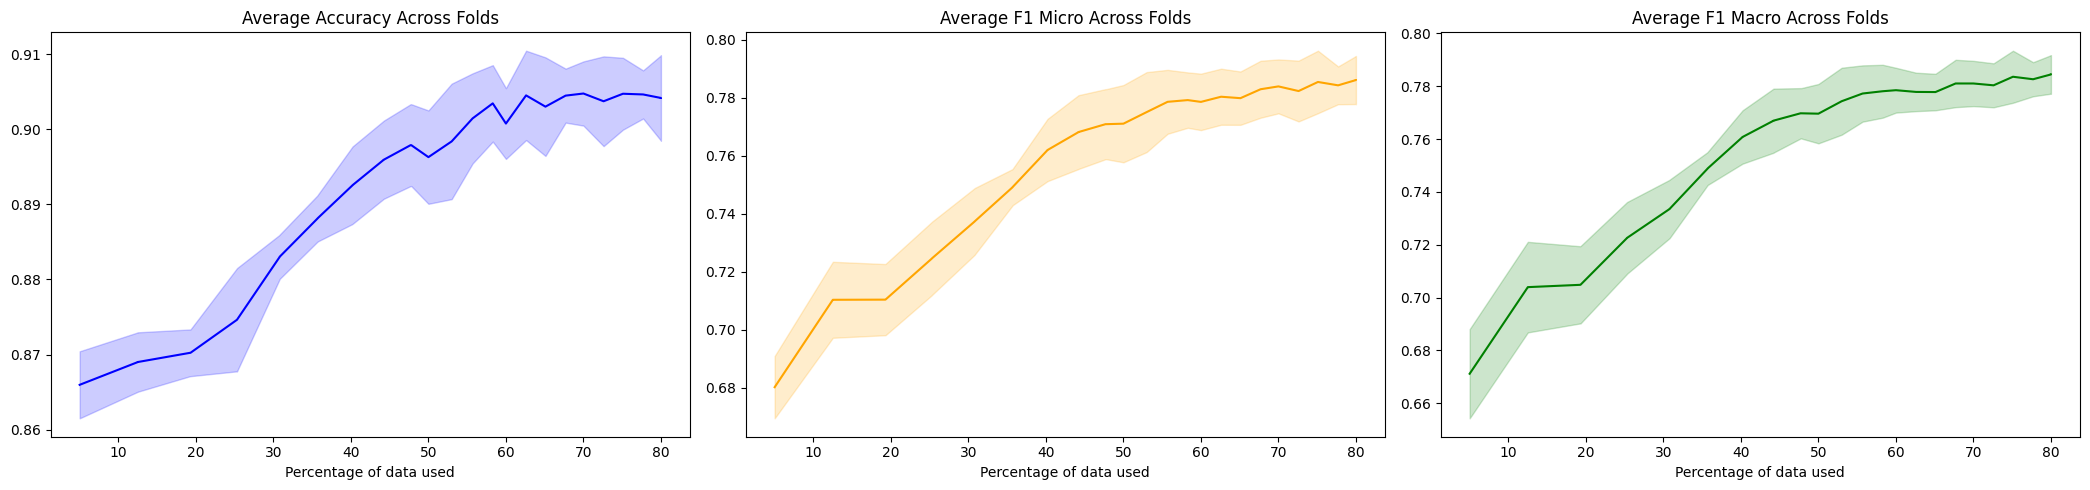

In [15]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)